In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

from skorch import NeuralNet
from skorch.dataset import CVSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.cuda.is_available()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Para lidar com o caminho relativo da pasta Scripts
import sys
sys.path.insert(0,'..')

from Scripts.data_processing import DataManager
from Scripts.models import VariationalAutoencoder, VAELoss, Recommender

In [5]:
DATA_PATH = '../dados/dados_treino.csv'
manager = DataManager(DATA_PATH)

In [6]:
manager.users

['#ID4940', '#ID9181']

Ajuste do modelo generativo

In [7]:
# O autoencoder variacional já está com alguns valores default dos parâmetros

# Ajusta o modelo para um usuário
USER = '#ID4940'

skorch_model = NeuralNet(
    module = VariationalAutoencoder,
    module__latent_dim = 35,
    module__hidden_dims = [40],
    criterion = VAELoss,
    optimizer = torch.optim.Adam,
    lr = 0.0001,
    max_epochs = 200,
    batch_size = 100,
    iterator_train__shuffle = True,
    train_split = CVSplit(0.2),
    device = device
)

# Ajuste de escala "treinado" para os dados do usuário selecionado
scaler = MinMaxScaler()

# Seleciona o conjunto de dados com curtida positiva, normaliza e passa transforma em Tensor
X, Y = manager.data_arrays(USER)
X = X[Y[:, 0] == 1]
scaler.fit(X)
X = scaler.transform(X)
X = torch.tensor(X).float().to(device)

# Ajusta o modelo
skorch_model.fit(X, X)

# Cria um MusicSampler para o usuário
sampler = Recommender(generativeModel = skorch_model.module_, evaluationModel = None, scaler = scaler, user = USER)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5309        0.5280  3.2416
      2        0.5266        0.5208  0.1366
      3        0.5217        0.5181  0.0838
      4        0.5187        0.5145  0.0588
      5        0.5140        0.5107  0.1307
      6        0.5120        0.5070  0.0410
      7        0.5071        0.5034  0.0444
      8        0.5068        0.5017  0.1259
      9        0.5019        0.4984  0.0399
     10        0.4983        0.4962  0.0951
     11        0.4951        0.4888  0.0509
     12        0.4905        0.4876  0.0529
     13        0.4868        0.4843  0.1986
     14        0.4850        0.4794  0.0583
     15        0.4807        0.4752  0.0489
     16        0.4780        0.4731  0.0529
     17        0.4735        0.4680  0.2069
     18        0.4698        0.4668  0.0369
     19        0.4661        0.4605  0.0455
     20        0.4623        0.4576  0.2054
     21        0.4587        0.4

In [8]:
recommendation_list = sampler.getMusicList(200, manager.data.drop(columns = ['id_cliente', 'data_curtida', 'n_reproducao', 'gostou']))

In [9]:
user_data = manager.user_data(USER)
user_data_liked = user_data[user_data['gostou'] == 1]

Text(0.5, 0.98, 'Curva de Densidade de Probabilidade do BMP')

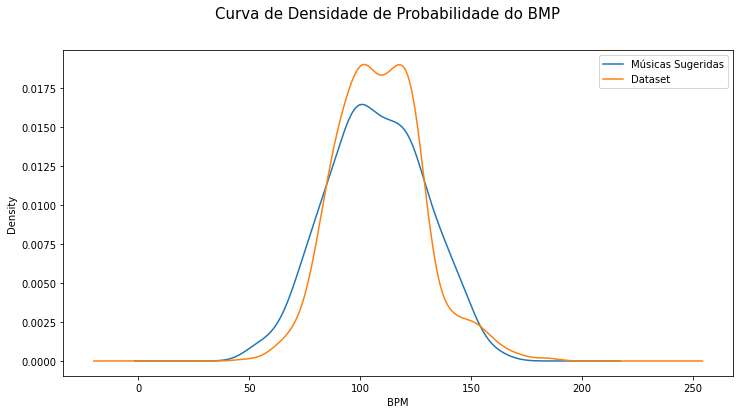

In [10]:
fig, ax = plt.subplots(figsize = (12, 6))

recommendation_list['BPM'].plot.density(ax = ax, label = 'Músicas Sugeridas')
user_data_liked['BPM'].plot.density(ax = ax, label = 'Dataset')

ax.legend()

ax.set_xlabel("BPM", fontsize = 10)
fig.suptitle("Curva de Densidade de Probabilidade do BMP", fontsize = 15)

Text(0.5, 0.98, 'Curva de Densidade de Probabilidade do Volume Médio')

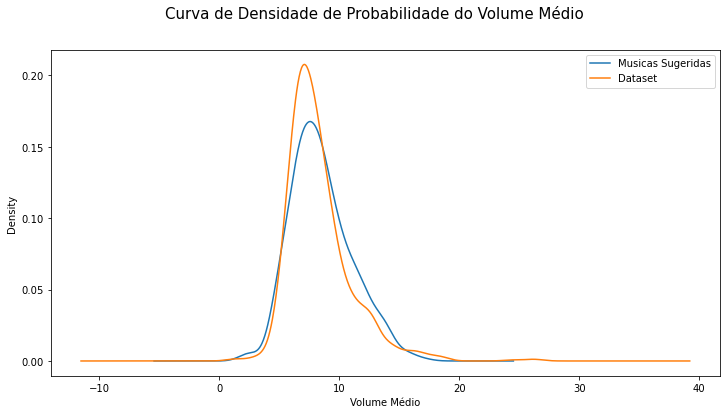

In [11]:
fig, ax = plt.subplots(figsize = (12, 6))

recommendation_list['VolMedio'].plot.density(ax = ax, label = 'Musicas Sugeridas')
user_data_liked['VolMedio'].plot.density(ax = ax, label = 'Dataset')

ax.legend()

ax.set_xlabel("Volume Médio", fontsize = 10)
fig.suptitle("Curva de Densidade de Probabilidade do Volume Médio", fontsize = 15)

Text(0.5, 0.98, 'Curva de Densidade de Probabilidade da Duração')

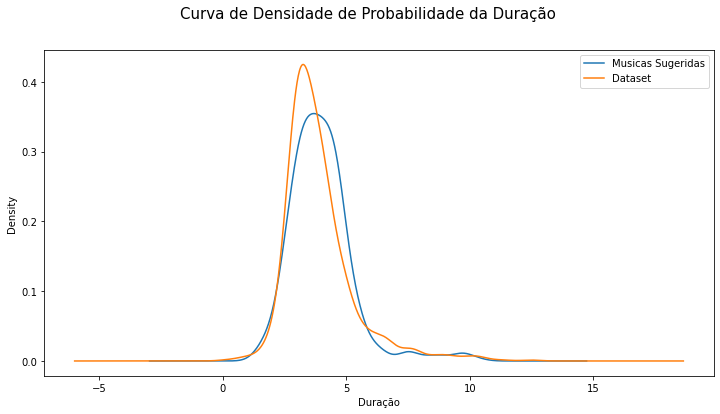

In [12]:
fig, ax = plt.subplots(figsize = (12, 6))

recommendation_list['duracao'].plot.density(ax = ax, label = 'Musicas Sugeridas')
user_data_liked['duracao'].plot.density(ax = ax, label = 'Dataset')

ax.legend()

ax.set_xlabel("Duração", fontsize = 10)
fig.suptitle("Curva de Densidade de Probabilidade da Duração", fontsize = 15)

Text(0.5, 0.98, 'Curva de Densidade de Probabilidade para %Cantada')

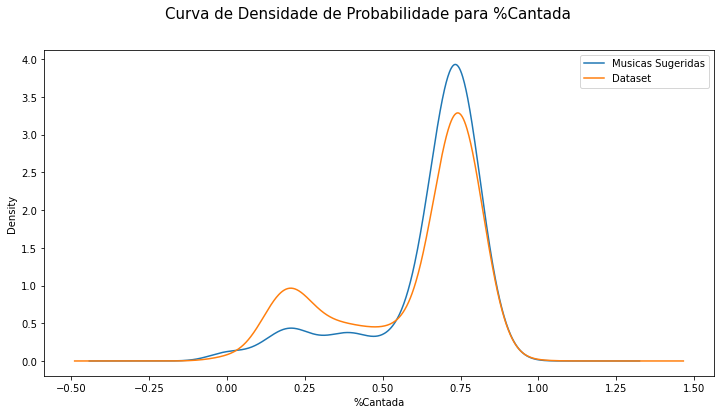

In [13]:
fig, ax = plt.subplots(figsize = (12, 6))

recommendation_list['PctCantada'].plot.density(ax = ax, label = 'Musicas Sugeridas')
user_data_liked['PctCantada'].plot.density(ax = ax, label = 'Dataset')

ax.legend()

ax.set_xlabel("%Cantada", fontsize = 10)
fig.suptitle("Curva de Densidade de Probabilidade para %Cantada", fontsize = 15)

Text(0.5, 0.98, 'Curva de Densidade de Probabilidade do %Rap')

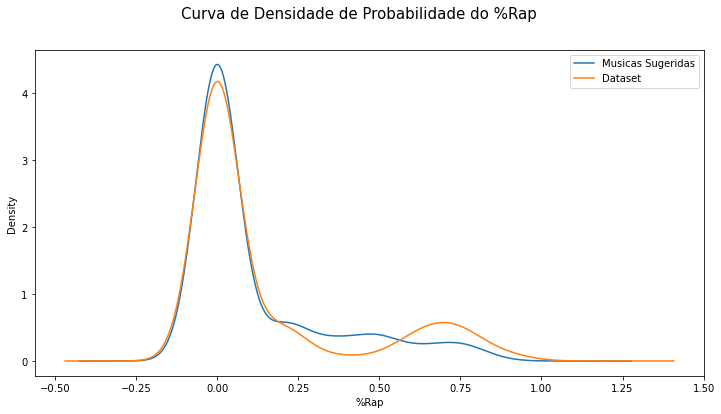

In [14]:
fig, ax = plt.subplots(figsize = (12, 6))

recommendation_list['PctRap'].plot.density(ax = ax, label = 'Musicas Sugeridas')
user_data_liked['PctRap'].plot.density(ax = ax, label = 'Dataset')

ax.legend()

ax.set_xlabel("%Rap", fontsize = 10)
fig.suptitle("Curva de Densidade de Probabilidade do %Rap", fontsize = 15)

Text(0.5, 0, 'Ano')

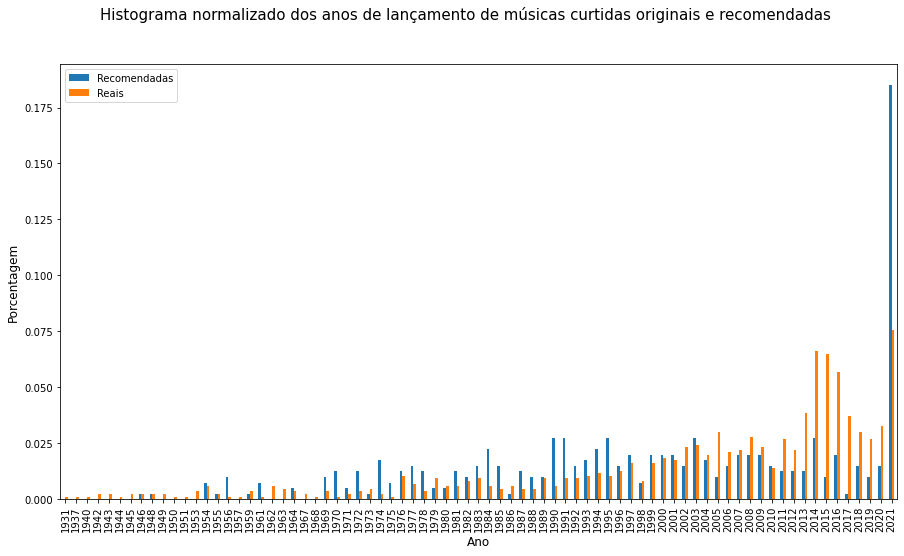

In [15]:
fig, ax = plt.subplots(figsize = (15, 8))

fig.suptitle("Histograma normalizado dos anos de lançamento de músicas curtidas originais e recomendadas", fontsize = 15)

ano_recomm = {ano: (recommendation_list['ano_lancamento'] == ano).sum() / len(recommendation_list) for ano in user_data_liked['ano_lancamento'].unique()}
ano_liked = {ano: (user_data_liked['ano_lancamento'] == ano).sum() / len(user_data_liked) for ano in user_data_liked['ano_lancamento'].unique()}
anos_df = pd.DataFrame({'Recomendadas': ano_recomm.values(), 'Reais': ano_liked.values()}, index = ano_liked.keys())
anos_df = anos_df.sort_index()
# anos_df = anos_df.iloc[70:]

anos_df.plot(kind = 'bar', ax = ax)

ax.set_ylabel("Porcentagem", fontsize = 12)
ax.set_xlabel("Ano", fontsize = 12)